<h1>Library Imports and Seeds</h1>

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors


# set a seed for reproducibility
np.random.seed(0)

<h1>Functions Definitions</h1>

In [39]:
# First, let's define some functions

#=================================================================================================================================#
#-----------------------------------------------------PREPROCESSING---------------------------------------------------------------#
#=================================================================================================================================#

# The function to preprocess the user table
def preprocess_user(user_filename):
    
    
    # load the csv file into the dataframe
    users_data = pd.read_csv(user_filename)

    # Part 1: UserID
    # drop non integer entry
    step1_data = users_data[users_data['User-ID'].astype(str).str.match(r'^\d+$')]

    # drop the entry for NaN UserID
    step1_data = users_data.dropna(subset=['User-ID'])

    # delete duplicate data
    step1_data = step1_data.drop_duplicates(subset=['User-ID'])

    
    # PART 2: Regional Data (City, State, Country)
    # Strip the regional columns off non alphabet characters, then normalize by making it lowercase
    step1_data['User-City'] = step1_data['User-City'].replace(r'[^a-zA-Z]', '', regex=True).str.lower()
    step1_data['User-State'] = step1_data['User-State'].replace(r'[^a-zA-Z]', '', regex=True).str.lower()
    step1_data['User-Country'] = step1_data['User-Country'].replace(r'[^a-zA-Z]', '', regex=True).str.lower()

    # replace full white space character or blank character to NaN
    step2_data = step1_data.replace(r'^\s*$', np.nan, regex=True)

    # change the exact "na" strings to NaN
    step2_data = step2_data.replace(r"^na$", np.nan, regex=True)

    # Impute the missing state using other state that have the same city
    # Create a mapping from cities to states
    city_to_state_map = step2_data.dropna(subset=['User-City', 'User-State']).drop_duplicates(subset=['User-City']).set_index('User-City')['User-State']

    # Use the map to fill missing states
    step2_data['User-State'] = step2_data['User-State'].fillna(step2_data['User-City'].map(city_to_state_map))

    # Impute the missing state using other state that have the same city
    # Create a mapping from states to countries
    state_to_country_map = step2_data.dropna(subset=['User-State', 'User-Country']).drop_duplicates(subset=['User-State']).set_index('User-State')['User-Country']

    # Use the map to fill missing countries
    step2_data['User-Country'] = step2_data['User-Country'].fillna(step2_data['User-State'].map(state_to_country_map))

    # drop the remaining NaNs
    step2_data = step2_data.dropna(subset=['User-State','User-Country'])

    # now that the state and country column is clean, we can drop city columnn since it won't be used
    step2_data = step2_data.drop(columns="User-City")

    
    # PART 3: Age column
    # strip every non numeric characters
    step2_data['User-Age'] = step2_data['User-Age'].astype(str).replace(r'[^\d]', "", regex=True)

    # change to int, change to NaN otherwise
    step2_data['User-Age'] = pd.to_numeric(step2_data['User-Age'], errors='coerce')

    # now replace out of range ages
    step2_data.loc[(step2_data['User-Age'] <= 0) | (step2_data['User-Age'] > 120), 'User-Age'] = np.nan

    # now, we drop the nan datas since it will ruin our model
    step2_data = step2_data.dropna(subset="User-Age")
    
    # now, use one hot encoding for Country and State
    step3_data = pd.get_dummies(step2_data, columns=['User-State', 'User-Country'])
    
    return step3_data


# The function to combine and preprocess the books table
def preprocess_books(books_filename, newbooks_filename):
    #Intitialize our datasets
    books = pd.read_csv(books_filename)
    new_books = pd.read_csv(newbooks_filename)
    series = [books, new_books]
    
    #Combine both books and newbooks to be one dataframe
    df_books = pd.concat(series)

    # Removing ISBN Duplicates
    df_books['ISBN'] = df_books['ISBN'].str.strip()  # Remove leading/trailing spaces
    df_books['ISBN'] = df_books['ISBN'].str.upper()  # Convert to upper case to ensure uniformity
    df_books = df_books.drop_duplicates(subset='ISBN', keep='first') 

    df_books['Year-Of-Publication'] = pd.to_numeric(df_books['Year-Of-Publication'], errors='coerce')

    # Year must be not bigger than 2024
    df_books = df_books.drop(df_books[df_books['Year-Of-Publication'] > 2024].index)
    df_books['Year-Of-Publication'] = df_books['Year-Of-Publication'].replace(0, np.nan) #replace 0 with NaNs
    
    # Book author must be capitalized, in special case where name start with Mc or Mac, it should be McName or MacName
    df_books['Book-Author'] = df_books['Book-Author'].apply(lambda name: ' '.join([
        'Mc' + part[2:].capitalize() if part.lower().startswith('mc') else
        'Mac' + part[3:].capitalize() if part.lower().startswith('mac') and len(part) > 3 else
        part.capitalize()
        for part in name.split()
    ]))

    return df_books


# The function to combine and preprocess the ratings table
def preprocess_ratings(ratings_filename, newratings_filename):
    # Initiallize our datasets
    ratings = pd.read_csv(ratings_filename)
    newratings_filename = pd.read_csv(newratings_filename)
    series = [ratings, newratings_filename]

    # Combine two datasets together
    df_ratings = pd.concat(series)

    # remove duplicates, one ISBN can only be rated by the same User-ID by one time
    df_ratings['ISBN'] = df_ratings['ISBN'].str.strip()  # Remove leading/trailing spaces
    df_ratings['ISBN'] = df_ratings['ISBN'].str.upper()  # Convert to upper case to ensure uniformity
    df_ratings = df_ratings.drop_duplicates(subset=['ISBN', 'User-ID'], keep='first')

    # Check for book-rating, can only be a range of 1-10. If book rating out of range, or NaN or empty, input the average of book rating'''
    df_ratings['Book-Rating'] = pd.to_numeric(df_ratings['Book-Rating'], errors='coerce')

    # Filter valid ratings and compute their average
    valid_ratings = df_ratings[(df_ratings['Book-Rating'] >= 1) & (df_ratings['Book-Rating'] <= 10)]
    df_ratings = valid_ratings.copy()

    return df_ratings


#====================================================================================================================================#
#-----------------------------------------------------MACHINE LEARNING---------------------------------------------------------------#
#====================================================================================================================================#

# A function to make a matrix where the rows consists of users and the column consists of books. 
# It stores the rating of each book by each user
def make_user_item_matrix(user_data, rating_data):
    # Merge dataframes
    merged_data = pd.merge(rating_data, user_data, on='User-ID')

    # Create user-item matrix
    user_item_matrix = pd.pivot_table(merged_data, values=['Book-Rating'], index=['User-ID'], columns='ISBN')

    # Flatten the multi-index column
    user_item_matrix.columns = ['_'.join(col) for col in user_item_matrix.columns.values]

    # Reset the index and the change the index to User-ID
    user_item_matrix = user_item_matrix.reset_index()
    user_item_matrix = user_item_matrix.set_index('User-ID')
    
    return user_item_matrix


# A function to split, that splits the data into test and train data. 
# The split is user based meaning the ratio is done on each entry to preserve each user data on train table
def split_user_based(matrix, test_ratio, is_cold_start):
    # Initialize training and testing DataFrames with NaNs
    train_df = pd.DataFrame(np.nan, columns=matrix.columns, index=matrix.index)
    test_df = pd.DataFrame(np.nan, columns=matrix.columns, index=matrix.index)
    
    if is_cold_start:
        # Identify users with exactly one rating
        single_rating_users = matrix.apply(lambda x: x.count(), axis=1) == 1
    
        # Calculate the number of these users to include in the test set
        test_users_count = int(len(single_rating_users[single_rating_users]) * test_ratio)
    
        # Sample users for the test set
        test_users = single_rating_users[single_rating_users].sample(n=test_users_count).index
        
        # Assign the single rating of these users to the test DataFrame and set to NaN in train DataFrame
        for user in test_users:
            rated_book = matrix.loc[user].dropna().index[0]
            test_df.at[user, rated_book] = matrix.at[user, rated_book]
            train_df.at[user, rated_book] = np.nan
            
        # Fill the rest of the train DataFrame
        remaining_users = matrix.index.difference(test_users)
        for user in remaining_users:
            user_ratings = matrix.loc[user].dropna()
            train_df.loc[user, user_ratings.index] = user_ratings

        return train_df, test_df
    else:
        # Splitting the data with consideration for NaNs
        for user in matrix.index:
            user_ratings = matrix.loc[user].dropna()  # Keep only non-NaN ratings
            test_ratings_count = int(len(user_ratings) * test_ratio)

            test_ratings = user_ratings.sample(n=test_ratings_count)
            train_ratings = user_ratings.drop(test_ratings.index)
                
            test_df.loc[user, test_ratings.index] = test_ratings
            train_df.loc[user, train_ratings.index] = train_ratings

        return train_df, test_df


# A function to prepare user data by adding weights and making everything numerical
def prepare_user_data(user_data, age_multiplier, region_multiplier):
    user_data = user_data.set_index('User-ID')

    # first, change boolean value to integer
    for column in user_data.columns:
        if user_data[column].dtype == 'bool':
            user_data[column] = user_data[column].astype(int)
            
    # now, add weight multiplier to age
    user_data.iloc[:, 0] = user_data.iloc[:, 0] * age_multiplier

    # add weight multiplier to countries and state
    user_data.iloc[:, 1:] = user_data.iloc[:, 1:] * region_multiplier
    
    return user_data


# A function to prepare the training data to be ready for KNN
# 1. imputing mean into NaN values
# 2. adding the age and region user data
def prepare_train_data(train_data, user_data):
    # Calculate the mean of each 'User-ID' value
    user_means = train_data.mean(axis=1)

    # Replace NaN means with the overall mean
    overall_mean = train_data.stack().mean()
    user_means.fillna(overall_mean, inplace=True)
    
    # For each user, impute the missing ratings using mean rating of each user
    train_data = train_data.T.fillna(user_means).T

    # merge the rating matrix with the user_table for extra features
    complete_train_data = train_data.merge(user_data, left_index=True, right_index=True, how='inner')

    return complete_train_data


#====================================================================================================================================#
#---------------------------------------------------------------TESTING--------------------------------------------------------------#
#====================================================================================================================================#

# A function to prepare test data by making the 3d test data matrix into a 2 dimensional data in the format of the original rating table
def prepare_test_data(test_data):
    test_data.index.name = 'user'
    complete_test_data = (test_data.reset_index()
                          .melt(id_vars='user', var_name='isbn', value_name='rating')
                          .dropna()
                          .reset_index(drop=True))
    return complete_test_data


# A function to compute similarity using distance
def compute_similarity(distance):
    similarity = 1 / (distance + 1)
    return similarity


# A function to find KNN, to find similar users and their distances
def find_similar_users(model, train_data, user_id, k_neighbors):
    distances, indices = model.kneighbors(train_data.loc[[user_id]], n_neighbors=k_neighbors+1)

    # Showing similar users and their distances
    distances = distances.flatten() # flatten to make it one dimensional
    similar_users = train_data.index[indices.flatten()] # find the userIDs of the indexes

    # now, need to filter for user_tested, a user is of course similar to himself
    mask = (similar_users != user_id) #an array of true and falses
    filtered_similar_users = similar_users[mask]
    filtered_distances = distances[mask]
    similarities = compute_similarity(filtered_distances)
    
    return filtered_similar_users, similarities


# Function to predict the rating of someone by finding the average rating of the similar users
def predict_rating(model, train_data, user_id, isbn, k_neighbors):
    similar_users, similarities= find_similar_users(model, train_data, user_id, k_neighbors)
    
    # Extract the ratings for the specified book from similar users
    neighbor_ratings = train_data.loc[similar_users, isbn]
    
    # Calculate the mean rating of the neighbors
    predicted_rating = np.average(neighbor_ratings, weights=similarities)
    
    return predicted_rating


def calculate_print_model_evaluation(errors, is_cold_start, test_ratio, region_multiplier, age_multiplier, title):
    # Calculate Mean Error (ME)
    me = np.mean(errors)

    # Calculate Mean Absolute Error (MAE)
    mae = np.mean(np.abs(errors))

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((errors) ** 2)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Calculate Standard Deviation of Errors
    error_std_dev = np.std(errors)
    
    print("=" * 61)
    print("||" + title.center(57) + "||")
    print("=" * 61)
    print("|| Settings:                                               ||")
    print(f"|| - Cold Start Testing           : {'Enabled ' if is_cold_start else 'Disabled'}               ||")
    print(f"|| - Test Ratio                   : {test_ratio:<23}||")
    print(f"|| - Region Multiplier            : {region_multiplier:<23}||")
    print(f"|| - Age Multiplier               : {age_multiplier:<23}||")
    print("=" * 61)
    print("|| Performance Metrics:                                    ||")
    print("|| ------------------------------------------------------- ||")
    print(f"|| - Mean Error (ME)              : {me:<23}||")
    print(f"|| - Mean Absolute Error (MAE)    : {mae:<23}||")
    print(f"|| - Mean Squared Error (MSE)     : {mse:<23}||")
    print(f"|| - Root Mean Squared Error      : {rmse:<23}||")
    print("=" * 61)
    print("|| Spread Metrics:                                         ||")
    print("|| ------------------------------------------------------- ||")
    print(f"|| - Standard Deviation of Errors : {error_std_dev:<23}||")
    print("=" * 61)


def plot_predicted_vs_observed(observed_rating, predicted_rating, title):
    plt.figure()
    # Increase marker size with 's' and reduce opacity with 'alpha'
    sns.scatterplot(x=observed_rating, y=predicted_rating, color='DarkBlue', s=50, alpha=0.2)
    plt.plot([0, 10], [0, 10], 'r--')  # Red dashed line for perfect predictions
    plt.title(title)
    plt.xlabel('Observed Rating')
    plt.ylabel('Predicted Rating')
    plt.grid(True)
    
    plt.show()
        

#====================================================================================================================================#
#-----------------------------------------------------WRAPPER FUNCTIONS--------------------------------------------------------------#
#====================================================================================================================================#
# These functions are made of smaller functions above, the objective is to test the model and make repetition easier

def build_model_and_predict(user_data, rating_data, is_cold_start, age_multiplier, region_multiplier, test_ratio):
    user_item_matrix = make_user_item_matrix(user_data, rating_data)

    train_data, test_data = split_user_based(user_item_matrix, test_ratio, is_cold_start)

    # add weight to user data (age, region)
    prepared_user_data = prepare_user_data(user_data, age_multiplier, region_multiplier)

    # merge user data (region, age) into train data
    complete_train_data = prepare_train_data(train_data, prepared_user_data)

    # Make the model
    k_neighbors = int(np.sqrt(len(complete_train_data)))
    model = NearestNeighbors(metric='euclidean', algorithm='brute', n_neighbors=k_neighbors+1, n_jobs=-1) # n_neighbors includes itself
    model.fit(complete_train_data)

    # prepare the test data
    complete_test_data = prepare_test_data(test_data)

    # find all predicted ratings for the data being tested
    predictions = []
    for row in complete_test_data.itertuples():
        prediction = predict_rating(model, complete_train_data, row.user, row.isbn, k_neighbors)
        predictions.append(prediction)
        
    observed_rating = complete_test_data['rating']
    predicted_rating = np.array(predictions)

    return observed_rating, predicted_rating


<h1>Preprocess Data</h1>

Before we start, let's preprocess the data necessary for the analysis

In [40]:
# PREPROCESS DATA
user_data = preprocess_user("BX-Users.csv")
book_data = preprocess_books("BX-Books.csv", "BX-NewBooks.csv")
rating_data = preprocess_ratings("BX-Ratings.csv", "BX-NewBooksRatings.csv")

<h1>1st Analysis: Base Evaluation of the Model</h1>

Here, we are trying to find the accuracy and evaluate the model. We decided to classify the model with age_multiplier = region_multiplier = 0.5 and test_ratio = 0.05 as the "Base" model. Here we do the evaluation twice, one for hot start and one for cold start.

In [41]:
# Base Hot Start Test

# Set parameters:
is_cold_start = False
age_multiplier = 0.5
region_multiplier = 0.5
test_ratio = 0.05
title = "Base Hot Start Model Evaluation"

observed_rating, predicted_rating = build_model_and_predict(user_data, rating_data, is_cold_start, age_multiplier, region_multiplier, test_ratio)
errors = observed_rating - predicted_rating

calculate_print_model_evaluation(errors, is_cold_start, test_ratio, region_multiplier, age_multiplier, title)

||             Base Hot Start Model Evaluation             ||
|| Settings:                                               ||
|| - Cold Start Testing           : Disabled               ||
|| - Test Ratio                   : 0.05                   ||
|| - Region Multiplier            : 0.5                    ||
|| - Age Multiplier               : 0.5                    ||
|| Performance Metrics:                                    ||
|| ------------------------------------------------------- ||
|| - Mean Error (ME)              : -0.01745157187851637   ||
|| - Mean Absolute Error (MAE)    : 1.155085572130216      ||
|| - Mean Squared Error (MSE)     : 2.3111002726071255     ||
|| - Root Mean Squared Error      : 1.5202303353791904     ||
|| Spread Metrics:                                         ||
|| ------------------------------------------------------- ||
|| - Standard Deviation of Errors : 1.5201301639156077     ||


In [42]:
# Base Cold Start Test

is_cold_start = True
age_multiplier = 0.5
region_multiplier = 0.5
test_ratio = 0.05
title = "Base Cold Start Model Evaluation"

observed_rating, predicted_rating = build_model_and_predict(user_data, rating_data, is_cold_start, age_multiplier, region_multiplier, test_ratio)
errors = observed_rating - predicted_rating

calculate_print_model_evaluation(errors, is_cold_start, test_ratio, region_multiplier, age_multiplier, title)

||             Base Cold Start Model Evaluation            ||
|| Settings:                                               ||
|| - Cold Start Testing           : Enabled                ||
|| - Test Ratio                   : 0.05                   ||
|| - Region Multiplier            : 0.5                    ||
|| - Age Multiplier               : 0.5                    ||
|| Performance Metrics:                                    ||
|| ------------------------------------------------------- ||
|| - Mean Error (ME)              : -0.14553267942727224   ||
|| - Mean Absolute Error (MAE)    : 1.3344941078275105     ||
|| - Mean Squared Error (MSE)     : 3.218233279349204      ||
|| - Root Mean Squared Error      : 1.7939434994863144     ||
|| Spread Metrics:                                         ||
|| ------------------------------------------------------- ||
|| - Standard Deviation of Errors : 1.7880306257354546     ||


<h1>2nd Analysis: Base Predicted vs Observed Value</h1>

Here, we are trying to find the pattern of errors in the data. The more the plot resembles the x=y line, the better the model is. In addition, we can see if the errors of the model has a constant variance which shows a good model. By "base" we still mean the model with age_multiplier = region_multiplier = 0.5 and test_ratio = 0.05. Here we do the evaluation twice, one for hot start and one for cold start.

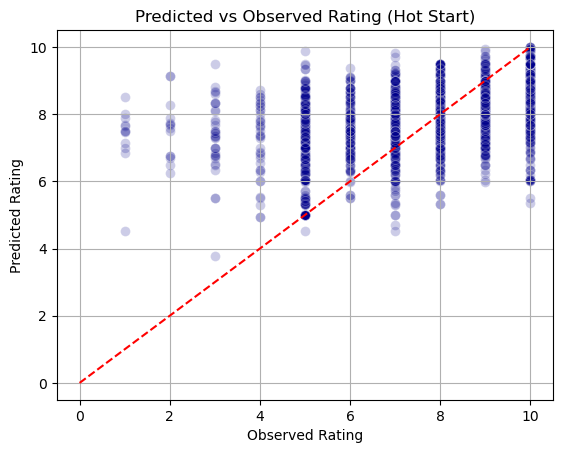

In [43]:
# Base Hot Start Plotting

# Set parameters:
is_cold_start = False
age_multiplier = 0.5
region_multiplier = 0.5
test_ratio = 0.05
title = "Predicted vs Observed Rating (Hot Start)"

observed_rating, predicted_rating = build_model_and_predict(user_data, rating_data, is_cold_start, age_multiplier, region_multiplier, test_ratio)

plot_predicted_vs_observed(observed_rating, predicted_rating, title)

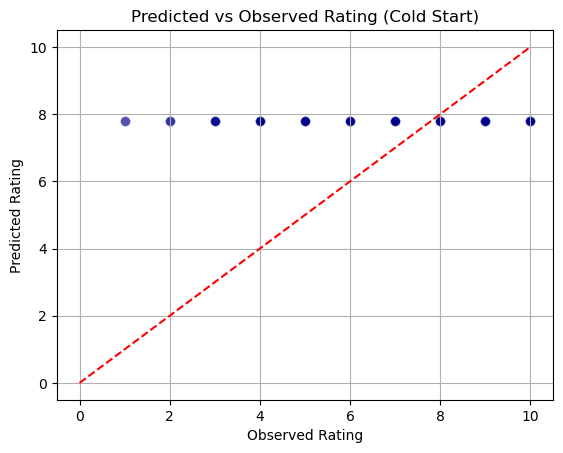

In [44]:
# Base Cold Start Plotting

# Set parameters:
is_cold_start = True
age_multiplier = 0.5
region_multiplier = 0.5
test_ratio = 0.05
title = "Predicted vs Observed Rating (Cold Start)"

observed_rating, predicted_rating = build_model_and_predict(user_data, rating_data, is_cold_start, age_multiplier, region_multiplier, test_ratio)

plot_predicted_vs_observed(observed_rating, predicted_rating, title)

<h1>3rd Analysis: MAE Plot for Different Age and Region Multiplier</h1>

Here, we are trying to find the relationship between different (age and region) multipliers and MAE as an accuracy metric of the model. We also provided 2 charts for each multipliers vlaue to show the relationship of higher multipliers to the cold start model testing as well as the hot start testing. The weights that we are going to test are 0, 0.5, and 1. 0 means that the model only uses the rating data without the age and region data of each user. 0.5 is the "regular" model. Lastly, 1 multiplier is used to test relatively high impact of the age and region multiplier to the data.

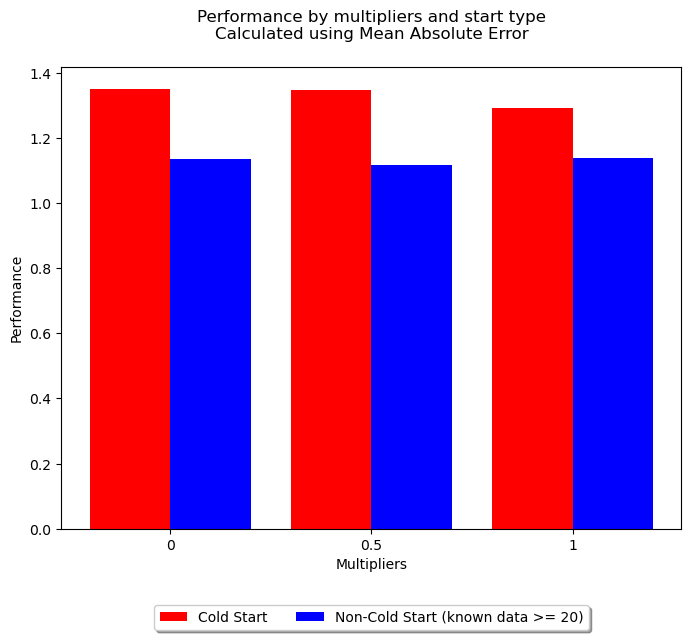

In [45]:
multipliers = [0, 0.5, 1]
hot_start_performance = []
cold_start_performance = []
for multiplier in multipliers:
    
    # Measure cold start MAE
    is_cold_start = True
    age_multiplier = multiplier
    region_multiplier = multiplier
    test_ratio = 0.05

    observed_rating, predicted_rating = build_model_and_predict(user_data, rating_data, is_cold_start, age_multiplier, region_multiplier, test_ratio)
    errors = observed_rating - predicted_rating
    mae = np.mean(np.abs(errors))
    cold_start_performance.append(mae)
    
    
    # Measure hot start MAE
    is_cold_start = False
    age_multiplier = multiplier
    region_multiplier = multiplier
    test_ratio = 0.05

    observed_rating, predicted_rating = build_model_and_predict(user_data, rating_data, is_cold_start, age_multiplier, region_multiplier, test_ratio)
    errors = observed_rating - predicted_rating
    mae = np.mean(np.abs(errors))
    hot_start_performance.append(mae)
    
    
# Positions of the bars on the x-axis
x_positions = [0, 1, 2]  # positions for the groups

# Creating the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Creating the bars
rects1 = ax.bar([x - 0.2 for x in x_positions], cold_start_performance, width=0.4, label='Cold Start', color='red')
rects2 = ax.bar([x + 0.2 for x in x_positions], hot_start_performance, width=0.4, label='Non-Cold Start (known data >= 20)', color='blue')

# Adding some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Multipliers')
ax.set_ylabel('Performance')
ax.set_title('Performance by multipliers and start type\nCalculated using Mean Absolute Error', pad=20)
ax.set_xticks(x_positions)
ax.set_xticklabels(multipliers)

# Placing the legend outside of the plot area
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

plt.show()